# Estimating Non-Diagonal Maps using Encoders

In [1]:
import sys
sys.path.append("../../../")
sys.path.append('../../')
import os
import time
import json
import torch
from tqdm import tqdm
from itertools import cycle
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import argparse
from torch.nn import functional as F
import matplotlib.pyplot as plt


from potential_flows import transforms, potential, encoders, data, flow
from potential_flows.data import get_dataset, create_custom_dataset
from flow.arguments import set_seed, parse_arguments, parse_notebook_arguments, get_parser

### Example 1: Eight Gaussian Mixture

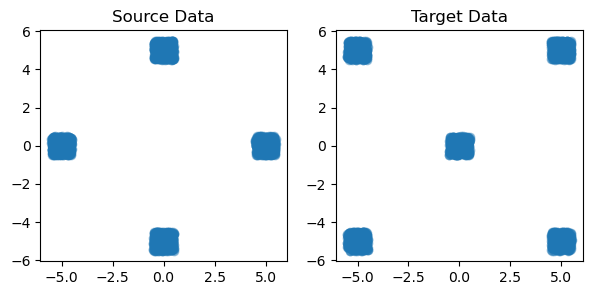

In [2]:
torch.manual_seed(42)
args = parse_notebook_arguments()
args.source_dist = "our_checker"
args.target_dist = "our_checker"
args.verbose = False
args.log_interval = 10

dataset_x, dataset_y = get_dataset(args, split = "train")  ## train dataset
test_x, test_y = get_dataset(args, split = "test")  ## test dataset
fig, axs = plt.subplots(1, 2, figsize = (7,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1], alpha=.4)
axs[0].set_title("Source Data")
axs[1].scatter(dataset_y.data[:,0], dataset_y.data[:,1], alpha=.4)
axs[1].set_title("Target Data")
plt.show()

### Dual Method

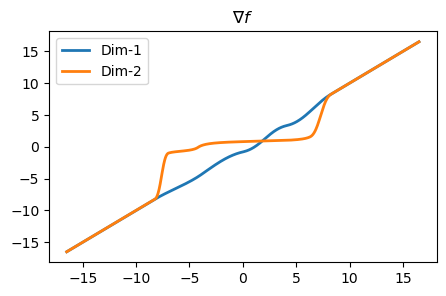

In [4]:
# creating the flow

tail_bound = torch.max(torch.cat([torch.abs(dataset_x.data), torch.abs(dataset_y.data)]))
potential_flow = potential.ICRQ(tail_bound=tail_bound*args.tail_factor, num_bins=4, data_shape=(2,))

# plotting the flow

potential_flow.plot_flow(1000)

In [5]:
# creating data loaders

data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

# creating OT Trainer

OT_Trainer = flow.DualOT_Trainer(potential_flow, args, dataset_x=data_loader_X, dataset_y=data_loader_Y, test_x=test_x, test_y=test_y)

In [6]:
OT_Trainer.learn()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 24%|██▍       | 1214/5000 [12:43<40:06,  1.57it/s] 

In [ ]:
OT_Trainer.potential_flow.plot_flow()

In [ ]:
# plotting train and test loss

with open(os.path.join(OT_Trainer.exp_dir, 'training_metrics.json'), "r") as json_file:
    train_specs = json.load(json_file)
train_specs = pd.DataFrame(train_specs)
num_logs = train_specs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
axs[0].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['train_loss'])
axs[1].plot(args.log_interval*(1+np.arange(num_logs)), train_specs['test_loss'])
plt.show()

As expected the diagonal map is unable to transport the checker example considered by Makkuva et. al. Therefore, we explore autoencoders, VAE, and PCA to find a latent distributions for source and target distribution that can be transported by diagonal map (using derivative of a ICRQ spline).

#### Principle Component Analysis

Since the proinciple componenets of the checkerboard data are aligned along the x and y axis, PCA leaves the data unchanged. Therefore, we conduct PCA based encoding for banana distribution.

In [21]:
# load dataset

args.source_dist = "banana"
args.target_dist = "gaussian"
dataset_x, dataset_y = get_dataset(args, split = "train")  ## train dataset
test_x, test_y = get_dataset(args, split = "test")  ## test dataset

# PCA with number of components = 2

n_components = 2
transform_x = encoders.PCA(n_components=n_components).fit(dataset_x.data)
transform_y = encoders.PCA(n_components=n_components).fit(dataset_y.data)

# create flow

tail_bound = args.tail_factor+torch.max(torch.abs(transform_x.encode(dataset_x.data))) + 0.5
potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=6, data_shape=(n_components,))

# data loaders

data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)

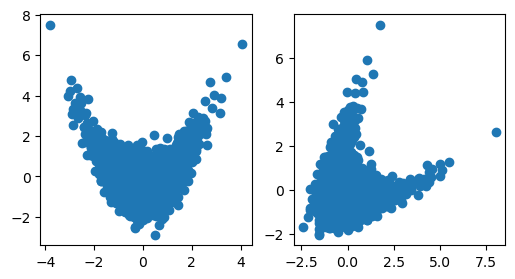

In [22]:
# plot transformed data using PCA

pca_Xtrain = data.CustomDataset(transform_x.encode(dataset_x.data))
fig, axs = plt.subplots(1, 2, figsize = (6,3))
axs[0].scatter(dataset_x.data[:,0], dataset_x.data[:,1])
axs[1].scatter(pca_Xtrain.data[:,0], pca_Xtrain.data[:,1])

In [ ]:
PCA_OT_Trainer = flow.DualPCA_OT_Trainer(potential=potential_flow,
                                    transform_x=transform_x,
                                    transform_y=transform_y,
                                    args=args,
                                    dataset_x=data_loader_X,
                                    dataset_y=data_loader_Y,
                                    test_x=test_x,
                                    test_y=test_y)
PCA_OT_Trainer.learn()

#### Autoencoder Potential Flow

Let us consider the simple case of high dimensional Gaussian and use autoencoders to find a smaller dimensional latent space representation of the source adnd target data. This transformed data is then transported using ICRQ spline based potential flows.

In [4]:
args = parse_notebook_arguments()
args.source_dist = 'gaussian'
args.target_dist = 'gaussian'
d = 1000
args.data_shape = (d,)

## create dataset and dataloaders

dataset_x, dataset_y = get_dataset(args, split="train")
test_x, test_y = get_dataset(args, split="test")
data_loader_X = DataLoader(dataset_x, batch_size=args.batch_size, shuffle=True)
data_loader_Y = DataLoader(dataset_y, batch_size=args.batch_size, shuffle=True)


In [5]:
hidden_dim = 512
latent_dim = 10
tail_bound = 1

# create autoencoders for source and target distribution

ae_x = encoders.AE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)
ae_y = encoders.AE(input_dim=np.prod(args.data_shape), hidden_dim=hidden_dim, latent_dim=latent_dim)

# potential flow

potential_flow = potential.ICRQ(tail_bound=tail_bound, num_bins=4, data_shape=(latent_dim,))

# train

AE_OT_Trainer = flow.DualAE_OT_Trainer(potential=potential_flow,
                                        transform_x=ae_x,
                                        transform_y=ae_y,
                                        args=args,
                                        dataset_x=data_loader_X,
                                        dataset_y=data_loader_Y,
                                        test_x=test_x,
                                        test_y=test_y)
AE_OT_Trainer.learn()

  0%|          | 0/5000 [00:00<?, ?it/s]/home/medhaaga/miniconda3/envs/nsf/lib/python3.10/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  2%|▏         | 97/5000 [02:15<1:52:34,  1.38s/it]

In [ ]:
AE_OT_Trainer.args.show_the_plot = True
AE_OT_Trainer.plot_flow()